# Team 5 Mini Project - BADM 554

# MILESTONE 1 AND 2

## Installing libraries

In [ ]:
!pip install sqlalchemy pyodbc pandas

In [ ]:
!pip install kagglehub

## Setting up connection to Azure SQL DB

In [1]:
from sqlalchemy import create_engine
import pandas as pd

# Azure SQL Database credentials
username = "gies"
password = "Password1"
server = "homework0.database.windows.net"
database = "Enterprise"

# Correct connection string (no :1433, no spaces in driver)
connection_string = (
    f"mssql+pyodbc://{username}:{password}@{server}/{database}"
    "?driver=ODBC+Driver+18+for+SQL+Server"
    "&Encrypt=yes"
    "&TrustServerCertificate=no"
    "&LoginTimeout=60"
    "&ConnectionTimeout=60"
)

# Create engine with fast uploads
engine = create_engine(connection_string, fast_executemany=True, pool_pre_ping=True)


### Testing the connection

In [2]:
from sqlalchemy import text

with engine.connect() as conn:
    result = conn.execute(text("SELECT GETDATE();"))
    for row in result:
        print(row)

(datetime.datetime(2025, 11, 4, 2, 31, 13, 603000),)


### Loading libraries and importing yelp data

In [28]:
import pandas as pd
import numpy as np
import json
import sqlalchemy
from sqlalchemy import create_engine

In [4]:
import kagglehub
yelp_dataset_yelp_dataset_path = kagglehub.dataset_download('yelp-dataset/yelp-dataset')

print('Data source import complete.')

Data source import complete.


In [5]:
import os
for dirname, _, filenames in os.walk(yelp_dataset_yelp_dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\ammra\.cache\kagglehub\datasets\yelp-dataset\yelp-dataset\versions\4\Dataset_User_Agreement.pdf
C:\Users\ammra\.cache\kagglehub\datasets\yelp-dataset\yelp-dataset\versions\4\yelp_academic_dataset_business.json
C:\Users\ammra\.cache\kagglehub\datasets\yelp-dataset\yelp-dataset\versions\4\yelp_academic_dataset_checkin.json
C:\Users\ammra\.cache\kagglehub\datasets\yelp-dataset\yelp-dataset\versions\4\yelp_academic_dataset_review.json
C:\Users\ammra\.cache\kagglehub\datasets\yelp-dataset\yelp-dataset\versions\4\yelp_academic_dataset_tip.json
C:\Users\ammra\.cache\kagglehub\datasets\yelp-dataset\yelp-dataset\versions\4\yelp_academic_dataset_user.json


# EXPLORING AND UPLOADING DATA TO AZURE 

## Check in Dataset

In [6]:
## Loading JSON data and storing in pandas dataframe

data_file_checkin = open(os.path.join(dirname, "yelp_academic_dataset_checkin.json"))
data_checkin = []
for line in data_file_checkin:
    data_checkin.append(json.loads(line))
checkin_df = pd.DataFrame(data_checkin)
data_file_checkin.close()

#### "Check-in for business" on Yelp is a user feature that allows a customer to mark their physical visit to a business through the Yelp app

In [ ]:
checkin_df.head()

In [ ]:
checkin_df.info()

#### Expanding the checkin_df dataset

In [ ]:
checkin_df1 = (
checkin_df.assign(date=checkin_df['date'].str.split(', ')).explode('date').reset_index(drop=True)
)
checkin_df1.head()

In [ ]:
## Dataset description
checkin_df1.describe()

1. Total number of rows after expanding the date field = 13,356,875
2. There are 131,930 unique businesses where users checked in at some point

In [ ]:
## Date Range:
print(checkin_df1['date'].max())
print(checkin_df1['date'].min())

 Dates are from 2009-12-30 to 2022-01-19

In [ ]:
## Top 10 businesses with highest check in counts
checkin_df1.groupby('business_id')['date'].agg(checkin_count = 'count').sort_values('checkin_count',ascending = False).head(10)

#### The primary key for checkin_df1 dataset would be a combination of business_id and check_in date


## Uploading to Azure SQL DB

In [ ]:
checkin_df1.to_sql("Check_in", con=engine, if_exists="replace", index=False, chunksize = 5000,
                   dtype={"business_id": NVARCHAR(50)})

In [ ]:
with engine.begin() as conn:
    # Make columns NOT NULL (required for PK)
    conn.execute(text("""
        ALTER TABLE Checkin
        ALTER COLUMN business_id NVARCHAR(50) NOT NULL;
    """))
    conn.execute(text("""
        ALTER TABLE Checkin
        ALTER COLUMN checkin_date DATETIME NOT NULL;
    """))

    # Add composite primary key
    conn.execute(text("""
        ALTER TABLE Checkin
        ADD CONSTRAINT PK_Checkin PRIMARY KEY (business_id, checkin_date);
    """))

print("Composite primary key set for Checkin")

## Tip Dataset 

In [34]:
## Loading JSON data and storing in pandas dataframe

data_file_tip = open(os.path.join(dirname, "yelp_academic_dataset_tip.json"), encoding="utf-8")
data_tip = []
for line in data_file_tip:
    data_tip.append(json.loads(line))
tip_df = pd.DataFrame(data_tip)
data_file_tip.close()

1. Tips are micro reviews given by users for each business. 
2. Compliment count is the number of compliments other users gave this review

In [35]:
tip_df.head()

,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0


In [36]:
tip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908915 entries, 0 to 908914
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           908915 non-null  object
 1   business_id       908915 non-null  object
 2   text              908915 non-null  object
 3   date              908915 non-null  object
 4   compliment_count  908915 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 34.7+ MB


In [37]:
print(tip_df['user_id'].nunique())
print(tip_df['business_id'].nunique())
print(tip_df['text'].nunique())
print(tip_df['date'].nunique())
print(tip_df['compliment_count'].nunique())

301758
106193
851033
906694
7


##### This means:
1. One user can write multiple tips for different businesses.
2. One business can receive multiple tips from different users.
3. The same text can appear in multiple rows.

In [38]:
## Date Range
print(tip_df['date'].max())
print(tip_df['date'].min())

2022-01-19 20:38:55
2009-04-16 13:11:49


### Dates are from 2009-04-16 to 2022-01-19

## Uploading to Azure SQL DB

In [41]:
tip_df.to_sql("tip", con=engine, if_exists="replace", index=False,chunksize = 5000, 
              dtype={'tip_id': sqlalchemy.types.NVARCHAR(50)
    })

-182

In [42]:
## Setting up tip_id as primary key in the tip table

with engine.begin() as conn:
    conn.execute(text("""
        ALTER TABLE Tip
        ADD CONSTRAINT PK_Tip PRIMARY KEY (tip_id);
    """))

ProgrammingError: (pyodbc.ProgrammingError) ('42S22', "[42S22] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]Column name 'tip_id' does not exist in the target table, index or view. (1911) (SQLExecDirectW); [42S22] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]Could not create constraint or index. See previous errors. (1750)")
[SQL: 
        ALTER TABLE Tip
        ADD CONSTRAINT PK_Tip PRIMARY KEY (tip_id);
    ]
(Background on this error at: https://sqlalche.me/e/20/f405)

## BUSINESS DATASET

In [10]:
## Loading JSON data and storing in pandas dataframe

data_file = open(os.path.join(dirname,"yelp_academic_dataset_business.json"),encoding="utf-8")
data = []
for line in data_file:
    data.append(json.loads(line))
business_df = pd.DataFrame(data)
data_file.close()

In [ ]:
business_df.head()

In [ ]:
business_df.info()

1. The dataset contains 150,346 businesses with 14 columns.
2. Some columns (attributes, categories, hours) have missing values.
3. Data types include text, numeric, and geographic fields.
4. Cleaning may be needed before analysis, especially expanding nested JSON fields in 'attributes' and 'hours'.

In [ ]:
## Missing values
business_df.isnull().sum()

In [ ]:
## Dataset description
business_df.describe()

1. The dataset contains 150,346 businesses with numeric data on location, rating, review counts, and status.
2. The average rating (stars) is ~3.6, with most businesses between 3.0 and 4.5 stars.
3. The average business has ~45 reviews, but counts range widely (up to 7,568).
4. About 80% of businesses are currently open.

In [ ]:
## Count of businesses per state
business_df['state'].value_counts().head(10)

1. The dataset includes businesses from multiple U.S. states and one Canadian province (AB = Alberta).
2. Pennsylvania (PA) has the largest number of businesses (~34K), followed by Florida (26K) and Tennessee (12K).

In [ ]:
## Count of businesses per city
business_df['city'].value_counts().head(10)

1. The dataset includes businesses from many cities, with Philadelphia leading (~14.5K businesses).
2. Tucson (9.2K) and Tampa (9.0K) follow, showing strong representation in the U.S. Southeast and Southwest.

In [ ]:
# Distribution of star ratings
business_df['stars'].value_counts().sort_index()

1. The most common rating is 4.0 stars (~31K businesses), followed by 4.5 and 3.5 stars.
2. Very few businesses have extremely low ratings (1.0–2.0), suggesting overall positive user experiences.
3. The distribution is right-skewed toward higher ratings, typical of review-based datasets.

In [ ]:
# Proportion of open vs closed businesses
business_df['is_open'].value_counts(normalize=True) * 100

About 79.6% of businesses in the dataset are currently open, while 20.4% are closed.

In [ ]:
# Businesses with most reviews
business_df[['name', 'city', 'stars', 'review_count']].sort_values('review_count', ascending=False).head(10)

In [ ]:
business_df['attributes'].head(5)

In [ ]:
# Extract all unique attribute keys
all_keys = set()

for attr in business_df['attributes'].dropna():
    if isinstance(attr, dict):
        all_keys.update(attr.keys())

print(f"Total unique keys: {len(all_keys)}")
print(sorted(all_keys)[:20])

1. The 'attributes' column contains 39 unique business characteristics.
2. These include operational features (e.g., 'DriveThru', 'ByAppointmentOnly'),amenities ('WiFi', 'BikeParking', 'BusinessParking'), and customer-related attributes ('GoodForKids', 'DogsAllowed', 'AcceptsInsurance').
####

### Removing nested and composite attributes from the business table

In [ ]:
business_main = business_df.drop(columns=['attributes', 'hours', 'categories'])

In [ ]:
# Splitting categories column - Creating a separate categories table
categories_df = business_df[['business_id', 'categories']].copy()
categories_df = categories_df.dropna(subset=['categories'])
categories_df = categories_df.assign(
    category=categories_df['categories'].str.split(', ')
).explode('category')[['business_id', 'category']]

In [ ]:
# Flatten Attributes
from pandas import json_normalize
attributes_df = json_normalize(business_df['attributes']).add_prefix("attr_")
attributes_df.columns = [col.replace('.', '_') for col in attributes_df.columns]

In [ ]:
# Flatten Hours
hours_df = json_normalize(business_df['hours']).add_prefix("hours_")

In [ ]:
#Combining business main with attributes and hours
business_flat = pd.concat([business_main, attributes_df, hours_df], axis=1)

In [ ]:
business_flat.shape

In [ ]:
categories_df.shape

In [ ]:
business_main.shape

## Uploading to Azure SQL DB

In [ ]:
#uploading business flattened table
business_flat.to_sql('Business', engine, if_exists='replace', index=False, chunksize=500)

In [ ]:
#uploading business category table
categories_df.to_sql('BusinessCategory', engine, if_exists='replace', index=False, chunksize=500)

In [9]:
## Setting up business_id as primary key in business table 

with engine.begin() as conn:
    conn.execute(text("""
        ALTER TABLE Business
        ADD CONSTRAINT PK_Business PRIMARY KEY (business_id);
    """))
print("Primary key set for Business")

Primary key set for Business


## User Dataset

In [14]:
## Loading JSON data and storing in pandas dataframe

data_file = open(os.path.join(dirname,"yelp_academic_dataset_user.json"),encoding="utf-8")
data = []
for line in data_file:
    data.append(json.loads(line))
user_df = pd.DataFrame(data)
data_file.close()

In [16]:
user_df.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


In [17]:
# Column types, missing values
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987897 entries, 0 to 1987896
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   name                object 
 2   review_count        int64  
 3   yelping_since       object 
 4   useful              int64  
 5   funny               int64  
 6   cool                int64  
 7   elite               object 
 8   friends             object 
 9   fans                int64  
 10  average_stars       float64
 11  compliment_hot      int64  
 12  compliment_more     int64  
 13  compliment_profile  int64  
 14  compliment_cute     int64  
 15  compliment_list     int64  
 16  compliment_note     int64  
 17  compliment_plain    int64  
 18  compliment_cool     int64  
 19  compliment_funny    int64  
 20  compliment_writer   int64  
 21  compliment_photos   int64  
dtypes: float64(1), int64(16), object(5)
memory usage: 333.7+ MB


In [18]:
#Summary of numeric columns
user_df.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06,1.987897e+06
mean,2.339441e+01,4.229634e+01,1.697054e+01,2.379291e+01,1.465740e+00,3.630494e+00,1.807072e+00,2.922631e-01,1.793176e-01,1.336493e-01,6.390723e-02,1.443135e+00,3.011841e+00,2.829308e+00,2.829308e+00,1.056448e+00,1.226859e+00
std,8.256699e+01,6.414806e+02,4.078034e+02,5.653513e+02,1.813075e+01,1.183337e+00,7.360184e+01,1.282467e+01,1.515525e+01,1.135682e+01,1.004363e+01,6.016790e+01,1.193898e+02,9.666385e+01,9.666385e+01,3.217973e+01,9.515751e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.880000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.700000e+01,1.300000e+01,2.000000e+00,3.000000e+00,0.000000e+00,4.560000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.747300e+04,2.062960e+05,1.858230e+05,1.998780e+05,1.249700e+04,5.000000e+00,2.578400e+04,1.350100e+04,1.418000e+04,1.365400e+04,1.266900e+04,5.903100e+04,1.010970e+05,4.996700e+04,4.996700e+04,1.593400e+04,8.263000e+04


In [19]:
# List all fields
user_df.columns

Index(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny',
       'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

In [21]:
# Missing data per column
user_df.isnull().sum()

user_id               0
name                  0
review_count          0
yelping_since         0
useful                0
funny                 0
cool                  0
elite                 0
friends               0
fans                  0
average_stars         0
compliment_hot        0
compliment_more       0
compliment_profile    0
compliment_cute       0
compliment_list       0
compliment_note       0
compliment_plain      0
compliment_cool       0
compliment_funny      0
compliment_writer     0
compliment_photos     0
dtype: int64

In [22]:
#Finding the earliest time and latest time period of users
user_df['yelping_since'] = pd.to_datetime(user_df['yelping_since'])
user_df['yelping_since'].min(), user_df['yelping_since'].max()

(Timestamp('2004-10-12 08:46:11'), Timestamp('2022-01-19 17:15:47'))

1. The Yelp Academic Dataset (user file) contains user-level information including review counts, join dates, and social interactions (useful, funny, cool).
2. There are ~1.6 M users, with data ranging from 2004 to 2024.
3. Each record has 22 fields, mostly numeric or string, and a few lists (e.g., friends).

In [23]:
user_df['friends'].head(3)

0    NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...
1    ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...
2    LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...
Name: friends, dtype: object

The friends field contains a comma-separated list of user IDs representing the user’s social connections on Yelp.
This is a nested string structure.

In [24]:
user_df['elite'].head(3)

0                                                 2007
1    2009,2010,2011,2012,2013,2014,2015,2016,2017,2...
2                             2009,2010,2011,2012,2013
Name: elite, dtype: object

This field lists the years when a user was designated as an “elite” member on Yelp.

In [25]:
user_df['useful'].head(3)

0     7217
1    43091
2     2086
Name: useful, dtype: int64

Column is a numeric variable representing how many times a user’s reviews have been marked as useful by others.

In [26]:
# Removing nested attributes from the user table
user_main = user_df.drop(columns=['elite'])

In [ ]:
# Splitting the elite column - creating a separate elite table
elite_df = user_df[['user_id', 'elite']].dropna(subset=['elite'])
elite_df = elite_df.assign(elite_year=elite_df['elite'].str.split(', '))
elite_df = elite_df.explode('elite_year')[['user_id', 'elite_year']]

In [ ]:
elite_df.shape

## Uploading to Azure SQL DB

In [29]:
# Uploading user table
user_main.to_sql('UserProfile', engine, if_exists='replace', index=False, chunksize=500, dtype={
        'user_id': sqlalchemy.types.NVARCHAR(25)})

-3976

In [31]:
## Setting primary key for user profile table
with engine.begin() as conn:
    # Make column NOT NULL
    conn.execute(text("""
        ALTER TABLE UserProfile
        ALTER COLUMN user_id NVARCHAR(25) NOT NULL;
    """))

    # Add primary key
    conn.execute(text("""
        ALTER TABLE UserProfile
        ADD CONSTRAINT PK_UserProfile PRIMARY KEY (user_id);
    """))

In [ ]:
# Uploading friends table
friends_df.to_sql('UserFriends', engine, if_exists='replace', index=False, chunksize=20000)

In [ ]:
# Uploading elite table
elite_df.to_sql('UserElite', engine, if_exists='replace', index=False, chunksize=10000)

## Review Dataset

In [32]:
## Loading JSON data and storing in pandas dataframe

data_file = open(os.path.join(dirname,"yelp_academic_dataset_review.json"),encoding="utf-8")
data = []
for line in data_file:
    data.append(json.loads(line))
review_df = pd.DataFrame(data)
data_file.close()

In [43]:
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [44]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   useful       int64  
 5   funny        int64  
 6   cool         int64  
 7   text         object 
 8   date         object 
dtypes: float64(1), int64(3), object(5)
memory usage: 480.0+ MB


In [45]:
print(review_df.describe())

              stars        useful         funny          cool
count  6.990280e+06  6.990280e+06  6.990280e+06  6.990280e+06
mean   3.748584e+00  1.184609e+00  3.265596e-01  4.986175e-01
std    1.478705e+00  3.253767e+00  1.688729e+00  2.172460e+00
min    1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00
25%    3.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
50%    4.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
75%    5.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
max    5.000000e+00  1.182000e+03  7.920000e+02  4.040000e+02


In [46]:
cool_reviews = review_df[review_df['cool'] > 0]['text']
funny_reviews = review_df[review_df['funny'] > 0]['text']
cool_and_funny = review_df[(review_df['cool'] > 0) & (review_df['funny'] > 0)]['text']

In [47]:
for text in cool_reviews[:5]: 
    print(text)
    print('-' * 50)

I've taken a lot of spin classes over the years, and nothing compares to the classes at Body Cycle. From the nice, clean space and amazing bikes, to the welcoming and motivating instructors, every class is a top notch work out.

For anyone who struggles to fit workouts in, the online scheduling system makes it easy to plan ahead (and there's no need to line up way in advanced like many gyms make you do).

There is no way I can write this review without giving Russell, the owner of Body Cycle, a shout out. Russell's passion for fitness and cycling is so evident, as is his desire for all of his clients to succeed. He is always dropping in to classes to check in/provide encouragement, and is open to ideas and recommendations from anyone. Russell always wears a smile on his face, even when he's kicking your butt in class!
--------------------------------------------------
Wow!  Yummy, different,  delicious.   Our favorite is the lamb curry and korma.  With 10 different kinds of naan!!!  Do

In [48]:
for text in funny_reviews[:5]: 
    print(text)
    print('-' * 50)

I am a long term frequent customer of this establishment. I just went in to order take out (3 apps) and was told they're too busy to do it. Really? The place is maybe half full at best. Does your dick reach your ass? Yes? Go fuck yourself! I'm a frequent customer AND great tipper. Glad that Kanella just opened. NEVER going back to dmitris!
--------------------------------------------------
Loved this tour! I grabbed a groupon and the price was great. It was the perfect way to explore New Orleans for someone who'd never been there before and didn't know a lot about the history of the city. Our tour guide had tons of interesting tidbits about the city, and I really enjoyed the experience. Highly recommended tour. I actually thought we were just going to tour through the cemetery, but she took us around the French Quarter for the first hour, and the cemetery for the second half of the tour. You'll meet up in front of a grocery store (seems strange at first, but it's not terribly hard to f

In [49]:
print(pd.to_datetime(review_df['date']).min())
print(pd.to_datetime(review_df['date']).max())
print(pd.to_datetime(review_df['date']).dt.year.unique())

2005-02-16 03:23:22
2022-01-19 19:48:45
[2018 2012 2014 2015 2017 2016 2009 2011 2013 2008 2010 2005 2007 2006
 2019 2020 2021 2022]


### Dates are from 2005-02-16 to 2022-01-19

## Uploading to Azure SQL DB

In [ ]:
review_df.to_sql("review", con=engine, if_exists="replace", index=False,chunksize = 5000)

In [33]:
## Setting primary key for review table

with engine.begin() as conn:
    conn.execute(text("""
        ALTER TABLE Review
        ADD CONSTRAINT PK_Review PRIMARY KEY (review_id);
    """))
print("Primary key set for Review")

ProgrammingError: (pyodbc.ProgrammingError) ('42000', "[42000] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]Column 'review_id' in table 'Review' is of a type that is invalid for use as a key column in an index. (1919) (SQLExecDirectW); [42000] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]Could not create constraint or index. See previous errors. (1750)")
[SQL: 
        ALTER TABLE Review
        ADD CONSTRAINT PK_Review PRIMARY KEY (review_id);
    ]
(Background on this error at: https://sqlalche.me/e/20/f405)

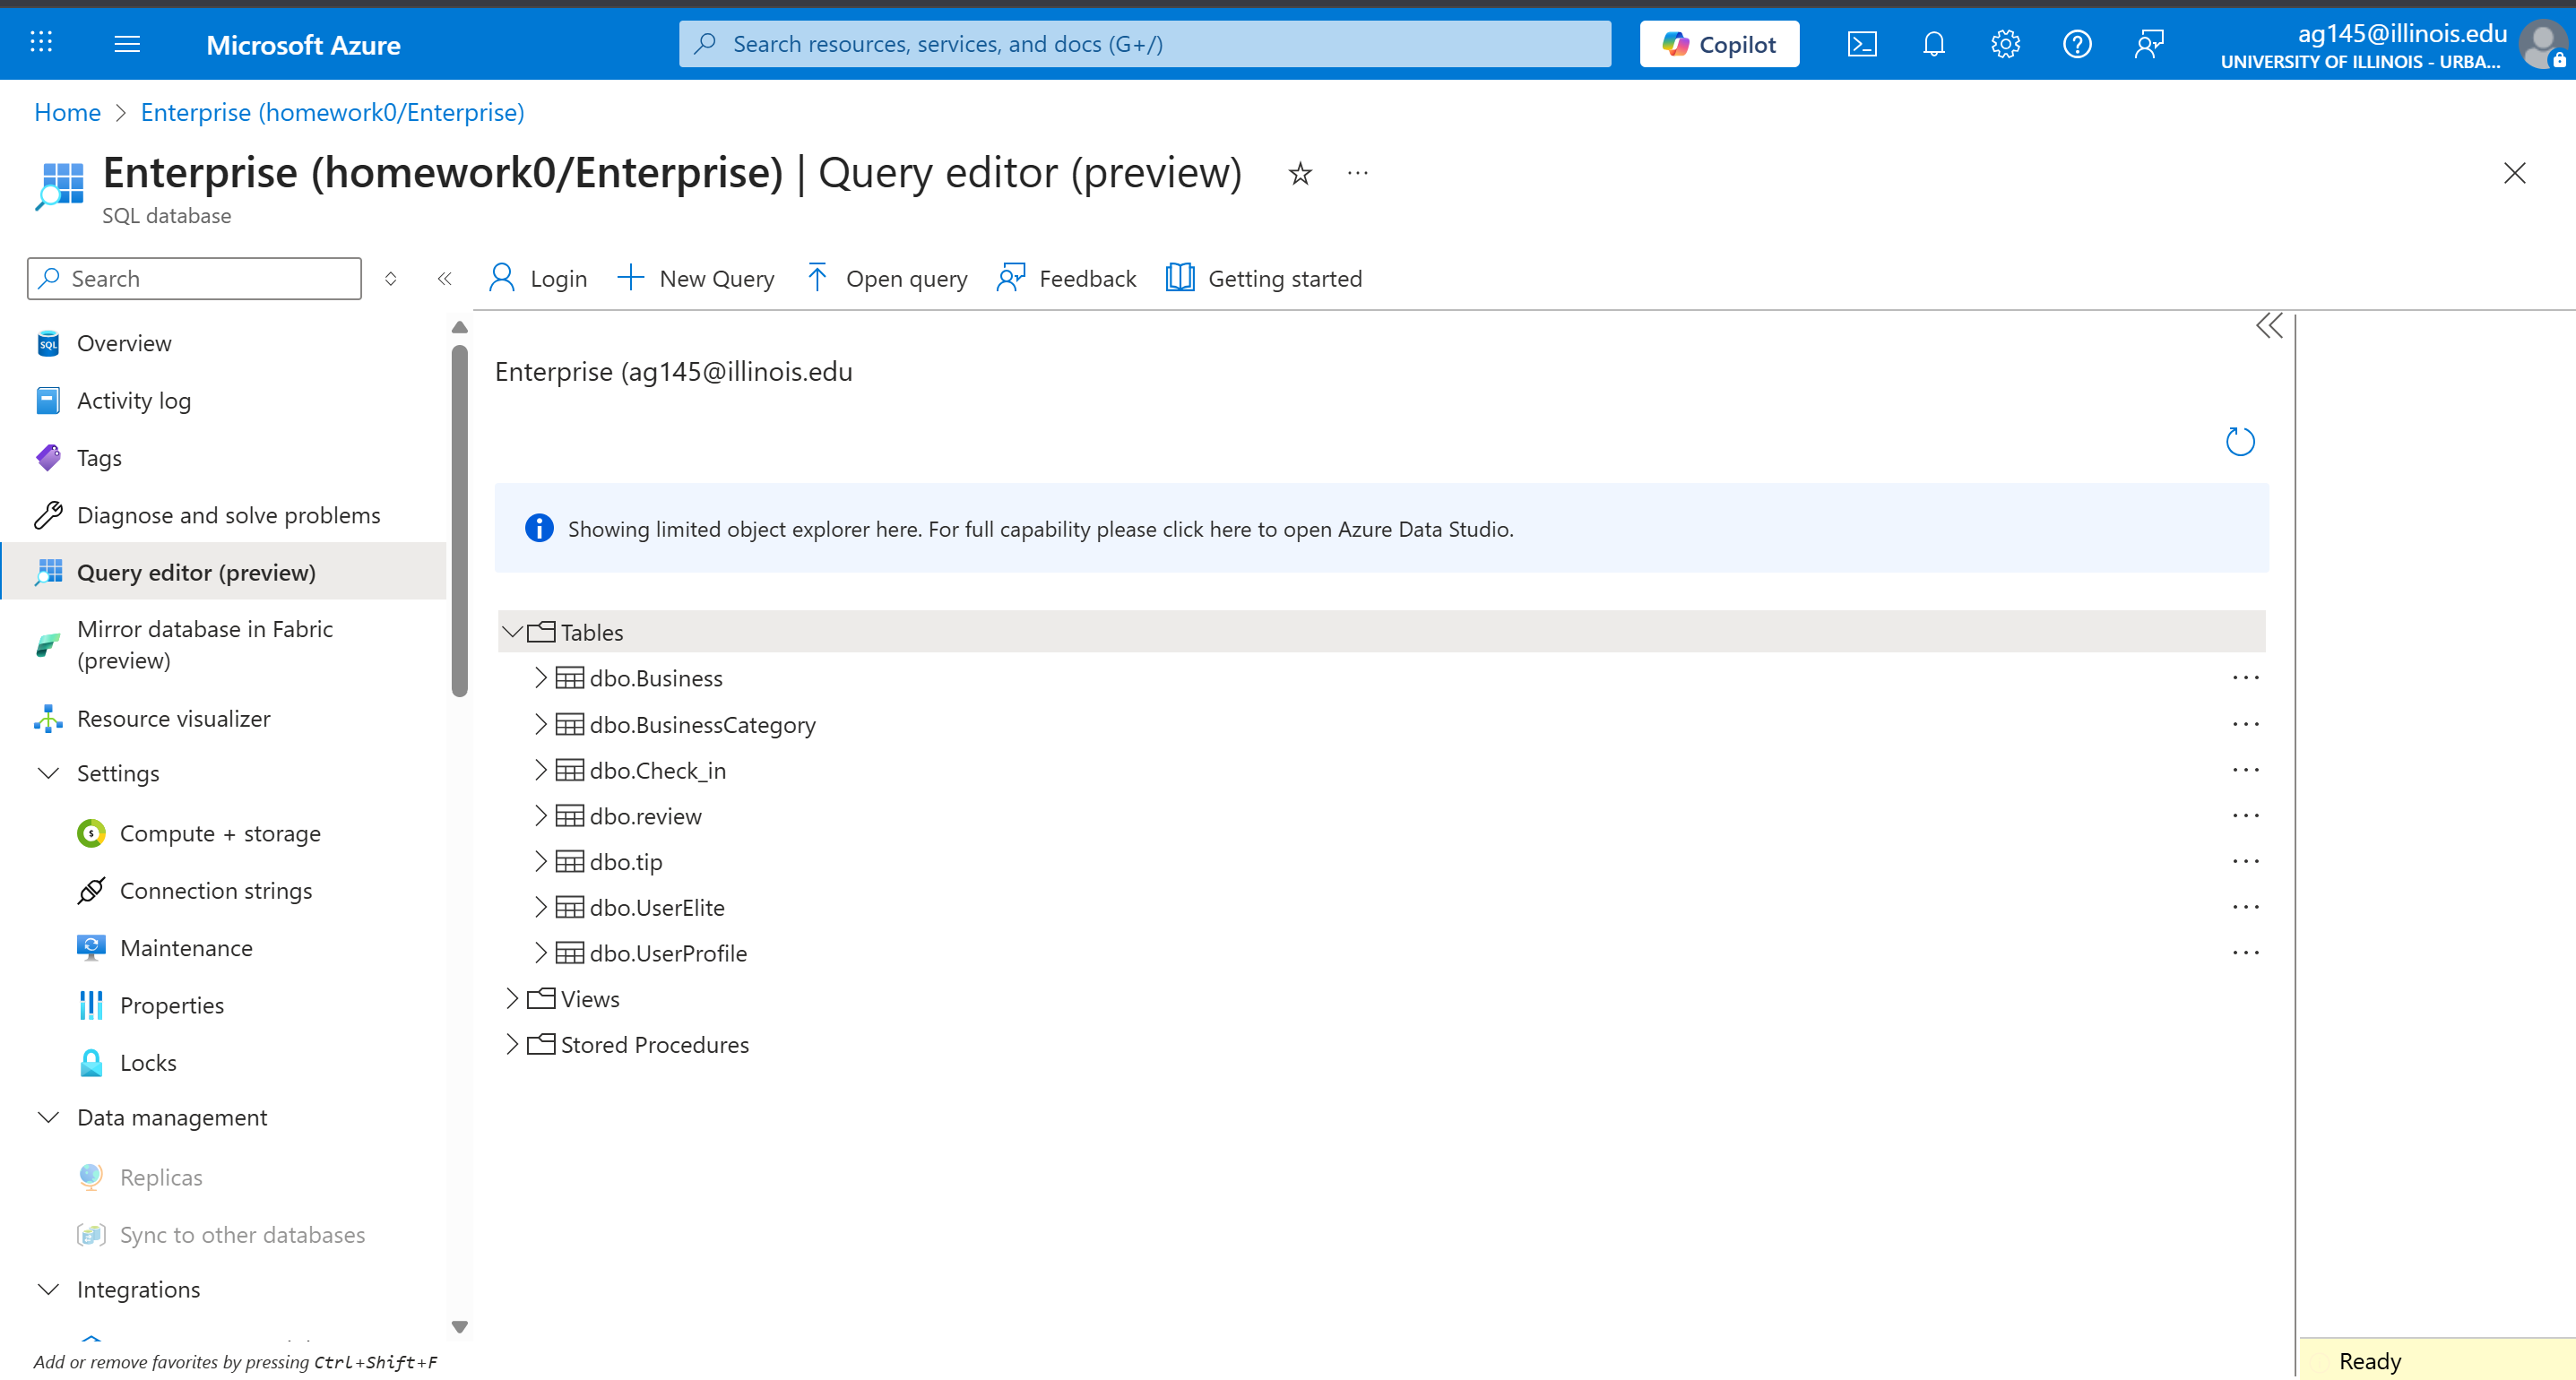

In [53]:
from IPython.display import Image, display

img = Image(filename='Azure SQL DB_yelp.png')
display(img)

# MILESTONE 3

### Concepts

#### Which city are you targeting and why?

#### Tampa, FL

Reason:
1. Diverse economy: Tampa’s mix of port (biggest of FL), mining, and tech provides a stable, year-round customer base.
2. Tourism hub: Over 26 million visitors per year create steady demand for dining and entertainment.
3. Food-forward culture: Ranked among the top U.S. culinary cities, with local markets encouraging new restaurants.
4. Growing population: Steady 1.3% annual growth and rising incomes expand dining demand.
5. High dining spending: Residents spend ~40% of food budgets on meals away from home.
6. Business-friendly: A low cost of living and operations attract restaurant investment.


#### What type of restaurant? (cuisine, price point, style) and Why?

#### Cuisine: Peruvian
#### Price Point: $30-$40 per person
#### Style: Dinner

Reason: World-renowned cuisine: Peru is repeatedly named the World’s Leading Culinary Destination.


#### Who is your target customer? and Why?

The target customers are young professionals, food enthusiasts, and tourists in Tampa who seek authentic, high-quality international cuisine, making Peruvian food an appealing choice in the city’s vibrant and growing dining scene.

### Analysis

Which area within Tampa has the least number of restaurants to find a market gap?

Results: We found 10 zip codes with only 1 restaurant in each which can be an indicator of a missing opportunity.
It shows what area of thew city are not restaurant heavy which we couldn’t easily tell from the dataset.

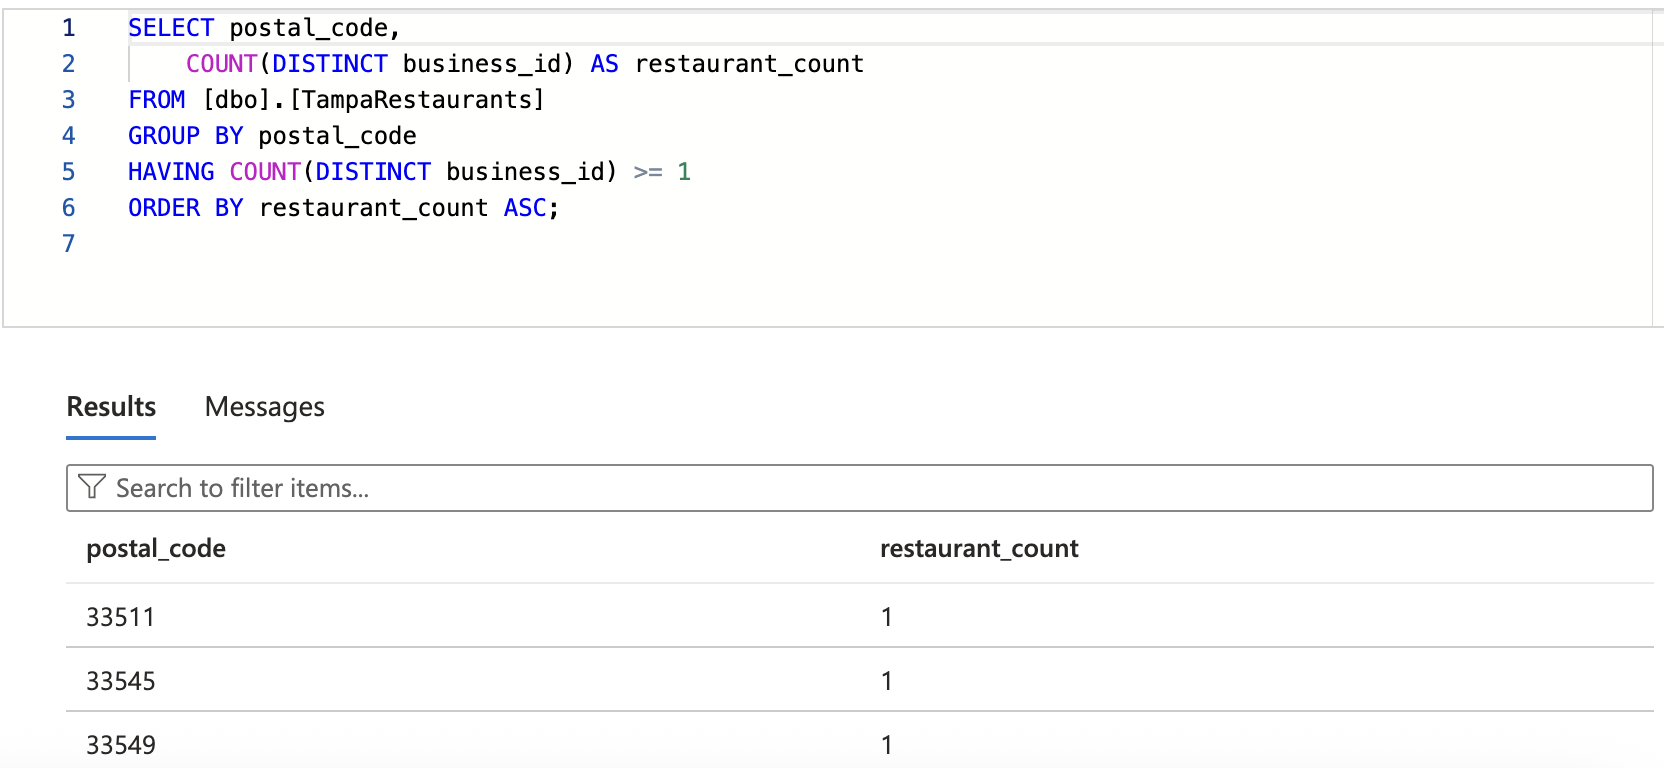

In [54]:
img1 = Image(filename='Query 1.png')
display(img1)

Which restaurant are the highest rated in the city. 

Results: we found many restaurants with >4.5-star reviews which are performing great which we could use for studying on how we could operate with our restaurant. 

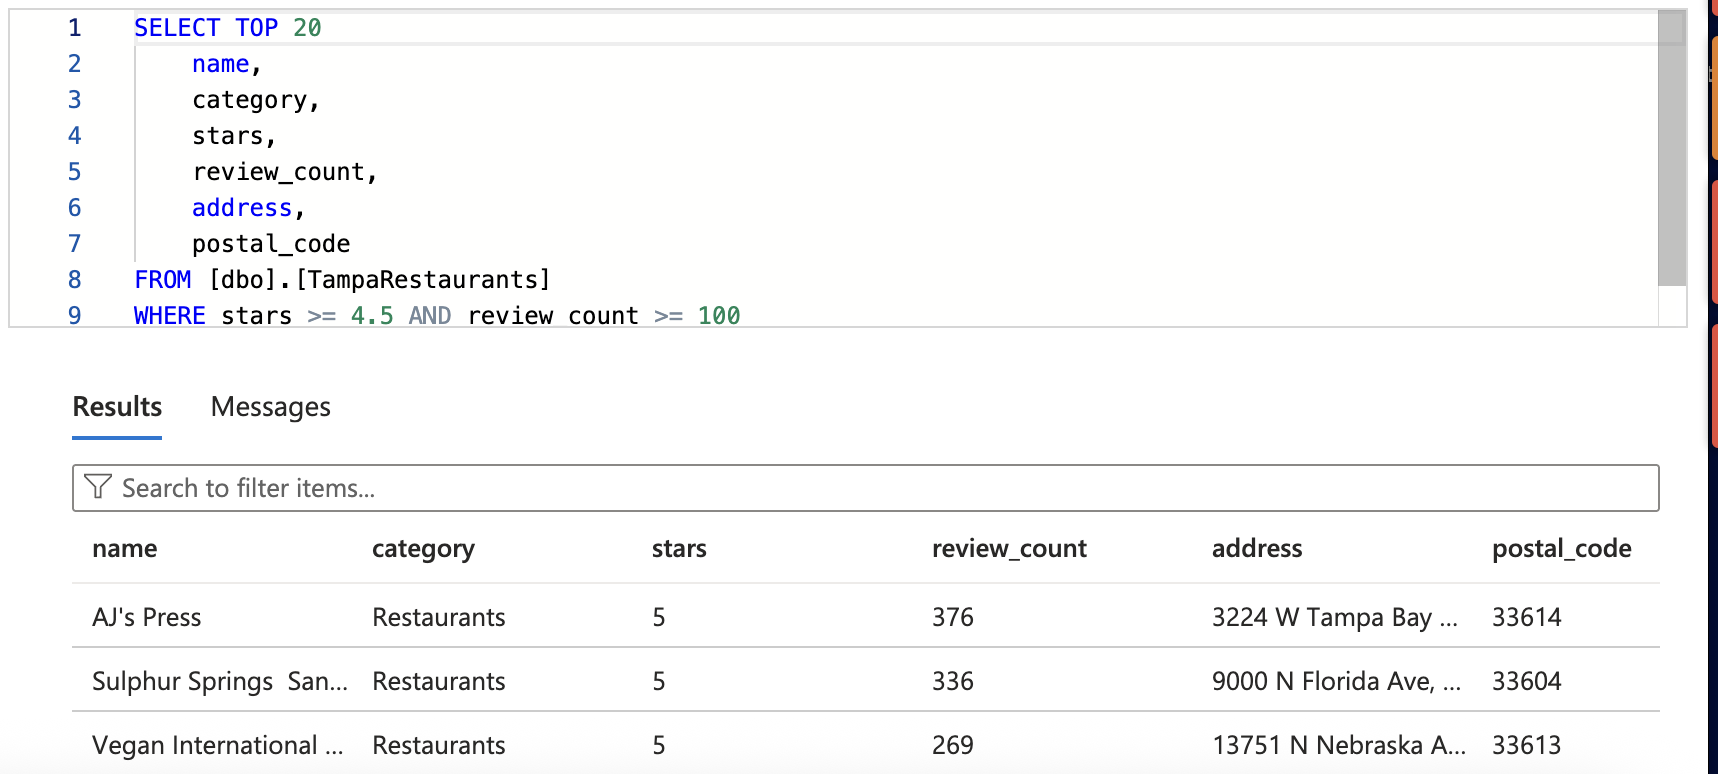

In [55]:
img2 = Image(filename='Query 2.png')
display(img2)

What restaurants are performing well within the areas that have only 1 restaurant.
    
Result: We found one restaurant that has 100 reviews with an average of 4.5. That indicates that most places where there is 1 restaurant within the area code, they are not performing great, and we could use that space to open a restaurant.

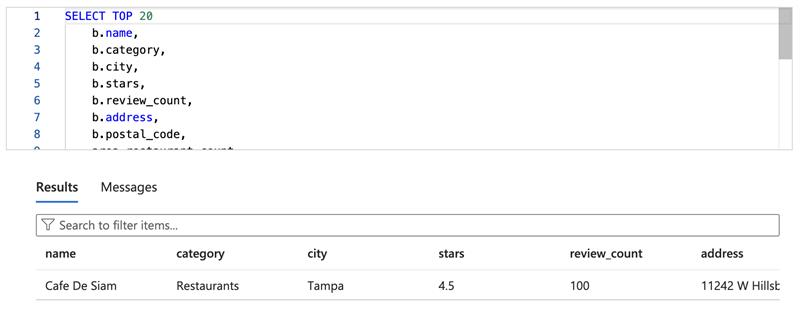

In [59]:
img3a = Image(filename='Query 3a.jpeg')
display(img3a)

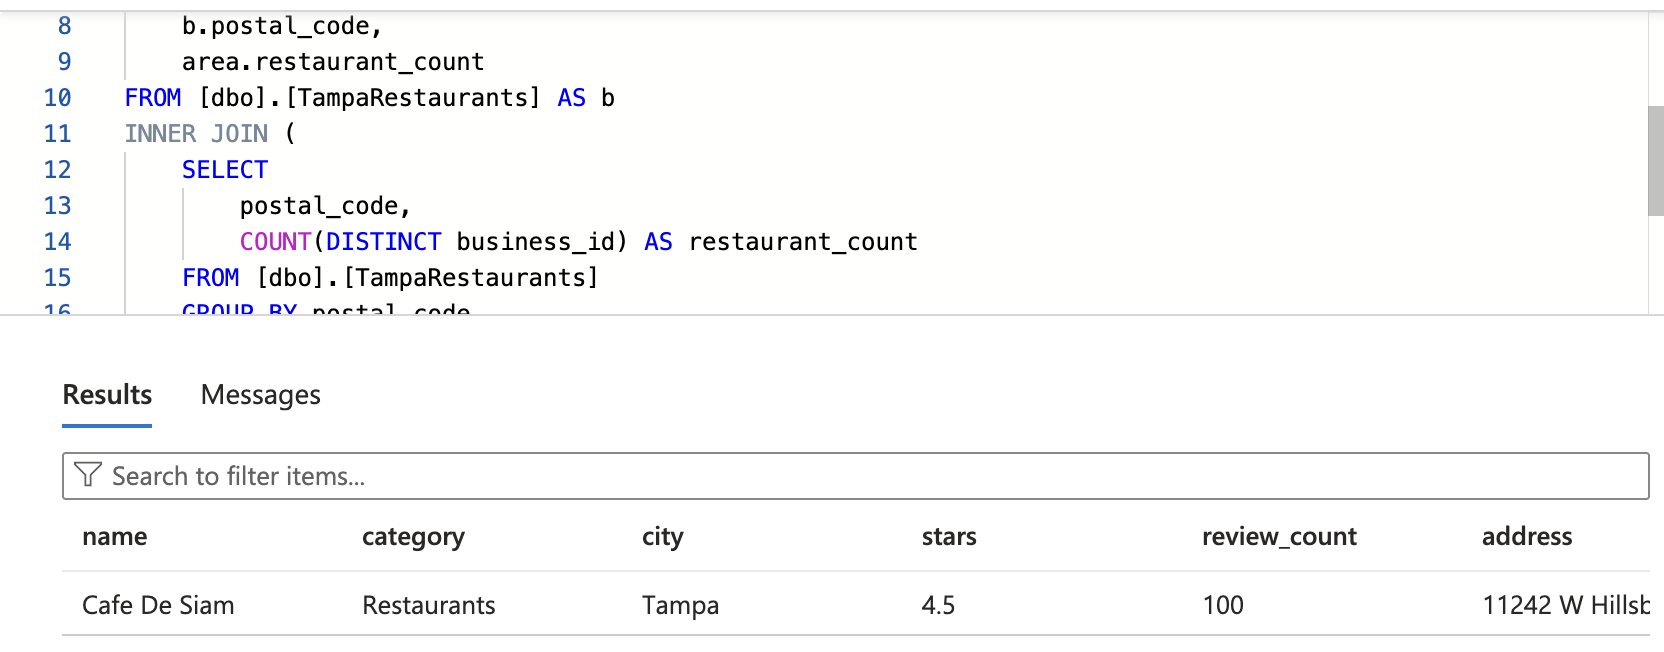

In [61]:
img3b = Image(filename='Query 3b.png')
display(img3b)

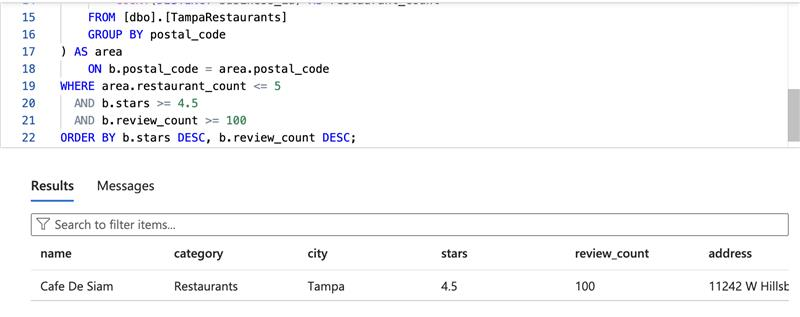

In [62]:
img3c = Image(filename='Query 3c.jpeg')
display(img3c)

How competitive the market is within the area. 
    
Results: The average rating when a restaurant is closed is 3.5 which on the scale of 5 rates quite high.

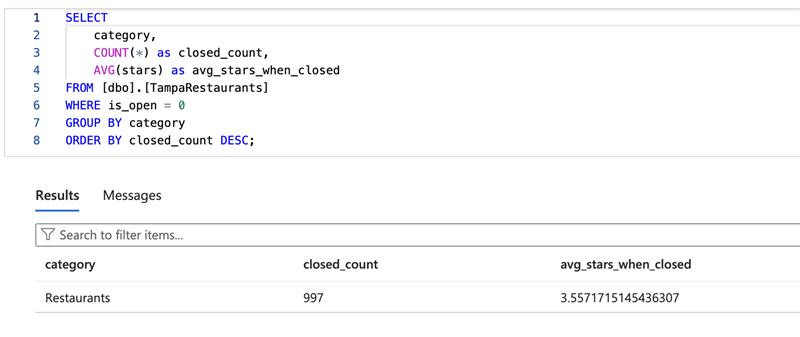

In [63]:
img4 = Image(filename='Query 4.jpeg')
display(img4)

How many restaurants are open and how many are closed. Overall market health - What % of Tampa restaurants survive?

Result: 33% percent of restaurants are closed in Tampa means the success rate is about 2/3.

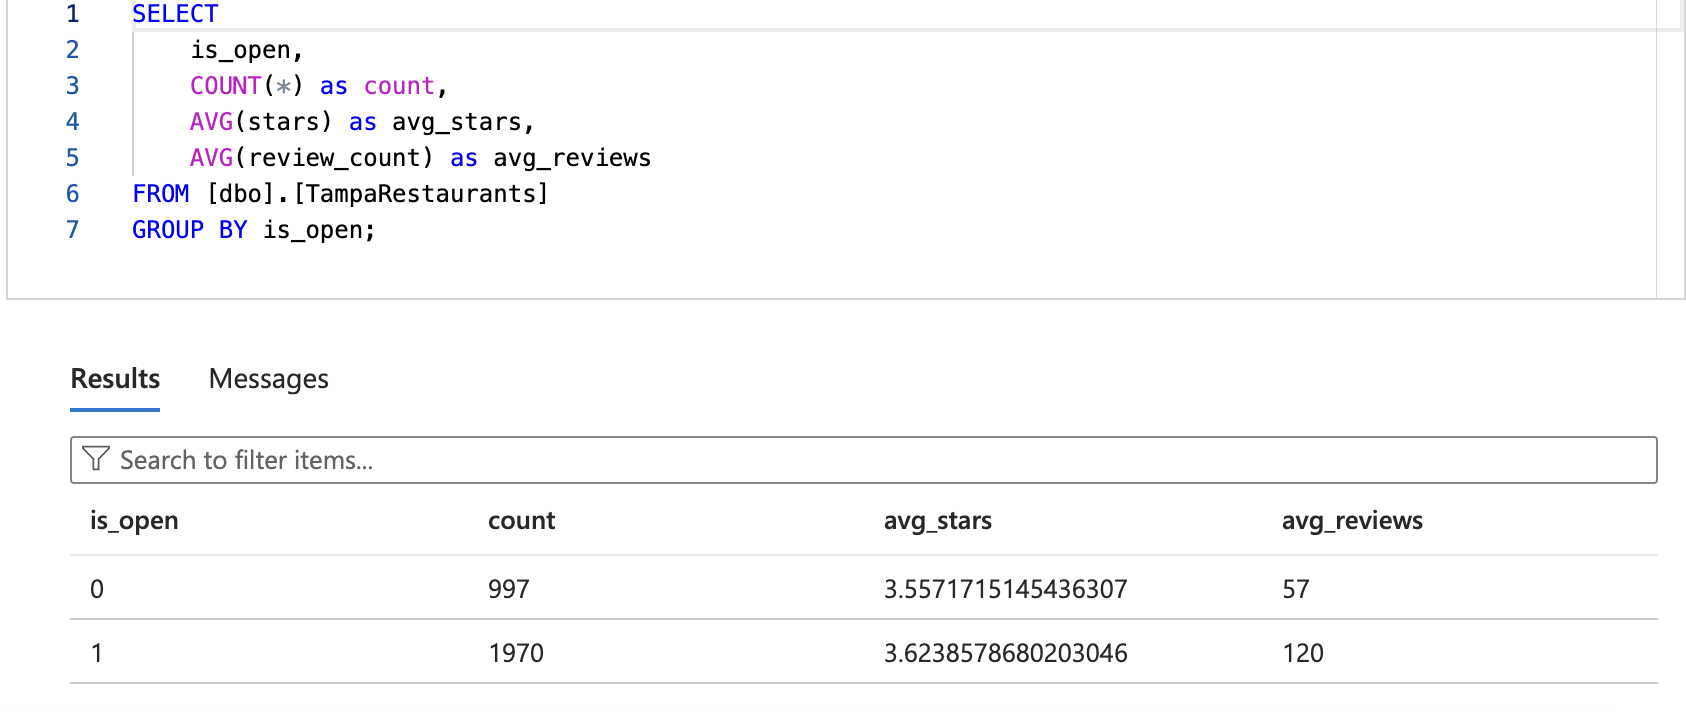

In [64]:
img5 = Image(filename='Query 5.png')
display(img5)

We are checking restaurants that have high numbers of reviews but poor scores.

Results: Restaurants with high engagement but poor ratings (lots of complaints), we can get most insight out of this since it shows that people continuously complain about those restaurants. 

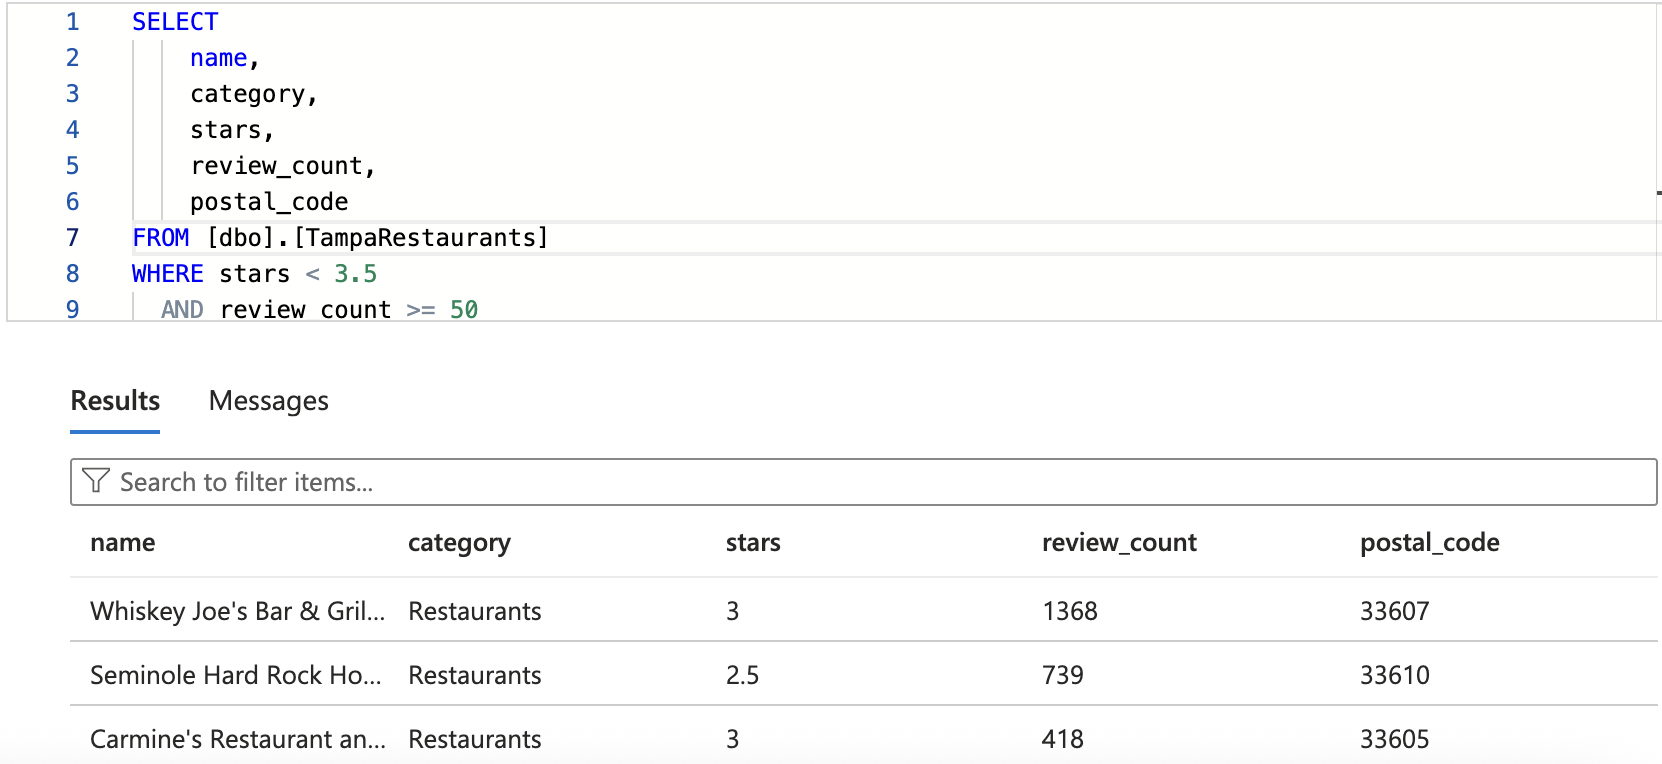

In [65]:
img6a = Image(filename='Query 6a.png')
display(img6a)

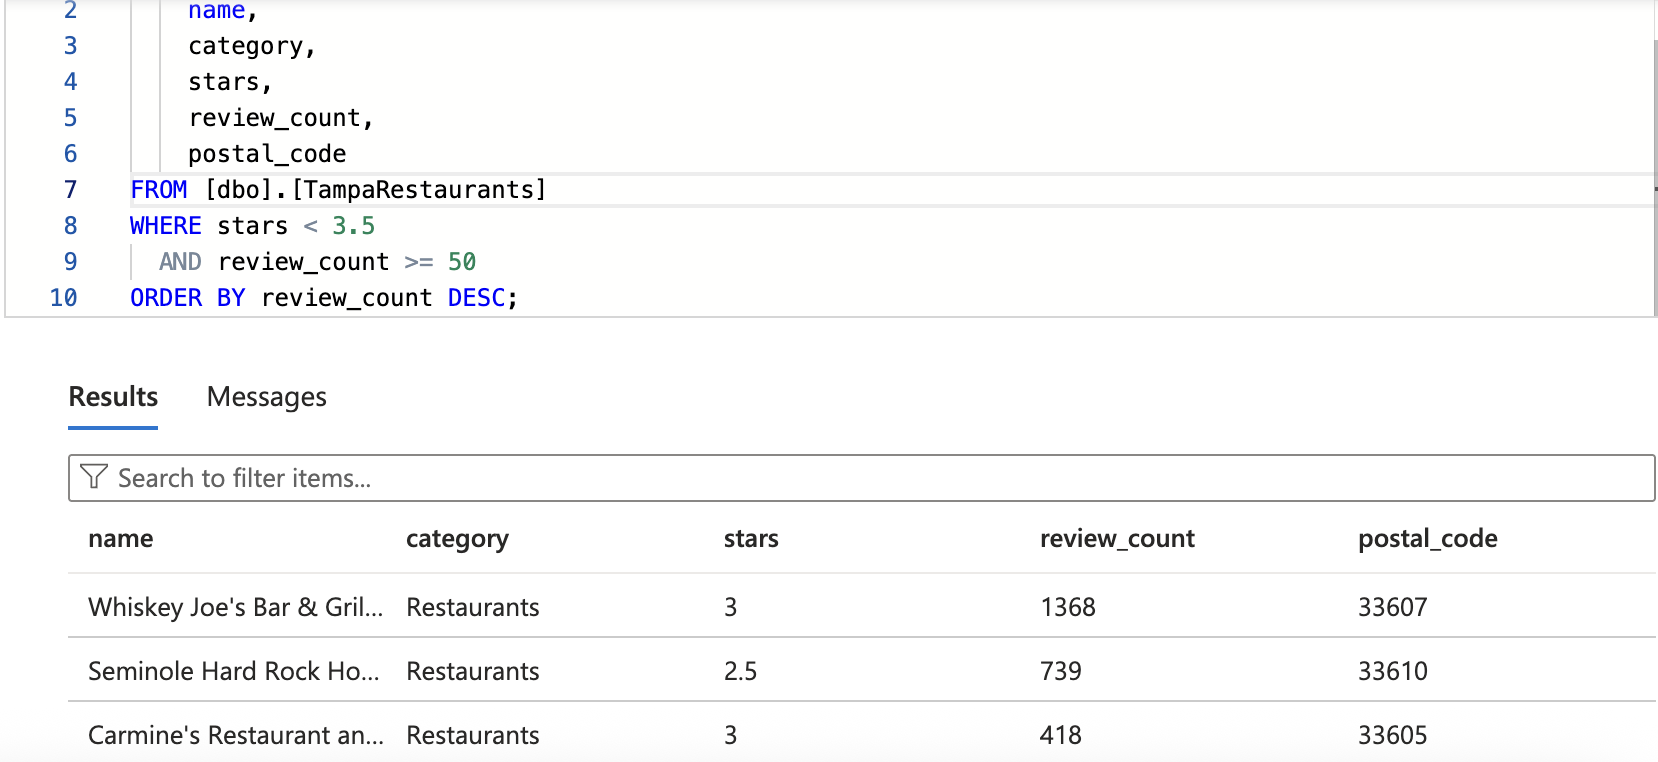

In [66]:
img6b = Image(filename='Query 6b.png')
display(img6b)

Checks areas within Tampa with lower customer satisfaction.

Results: Customers in these neighborhoods may be harder to please; we found 24 areas with struggling restaurants. Local competition might be struggling for a reason which can help us decide against those areas.

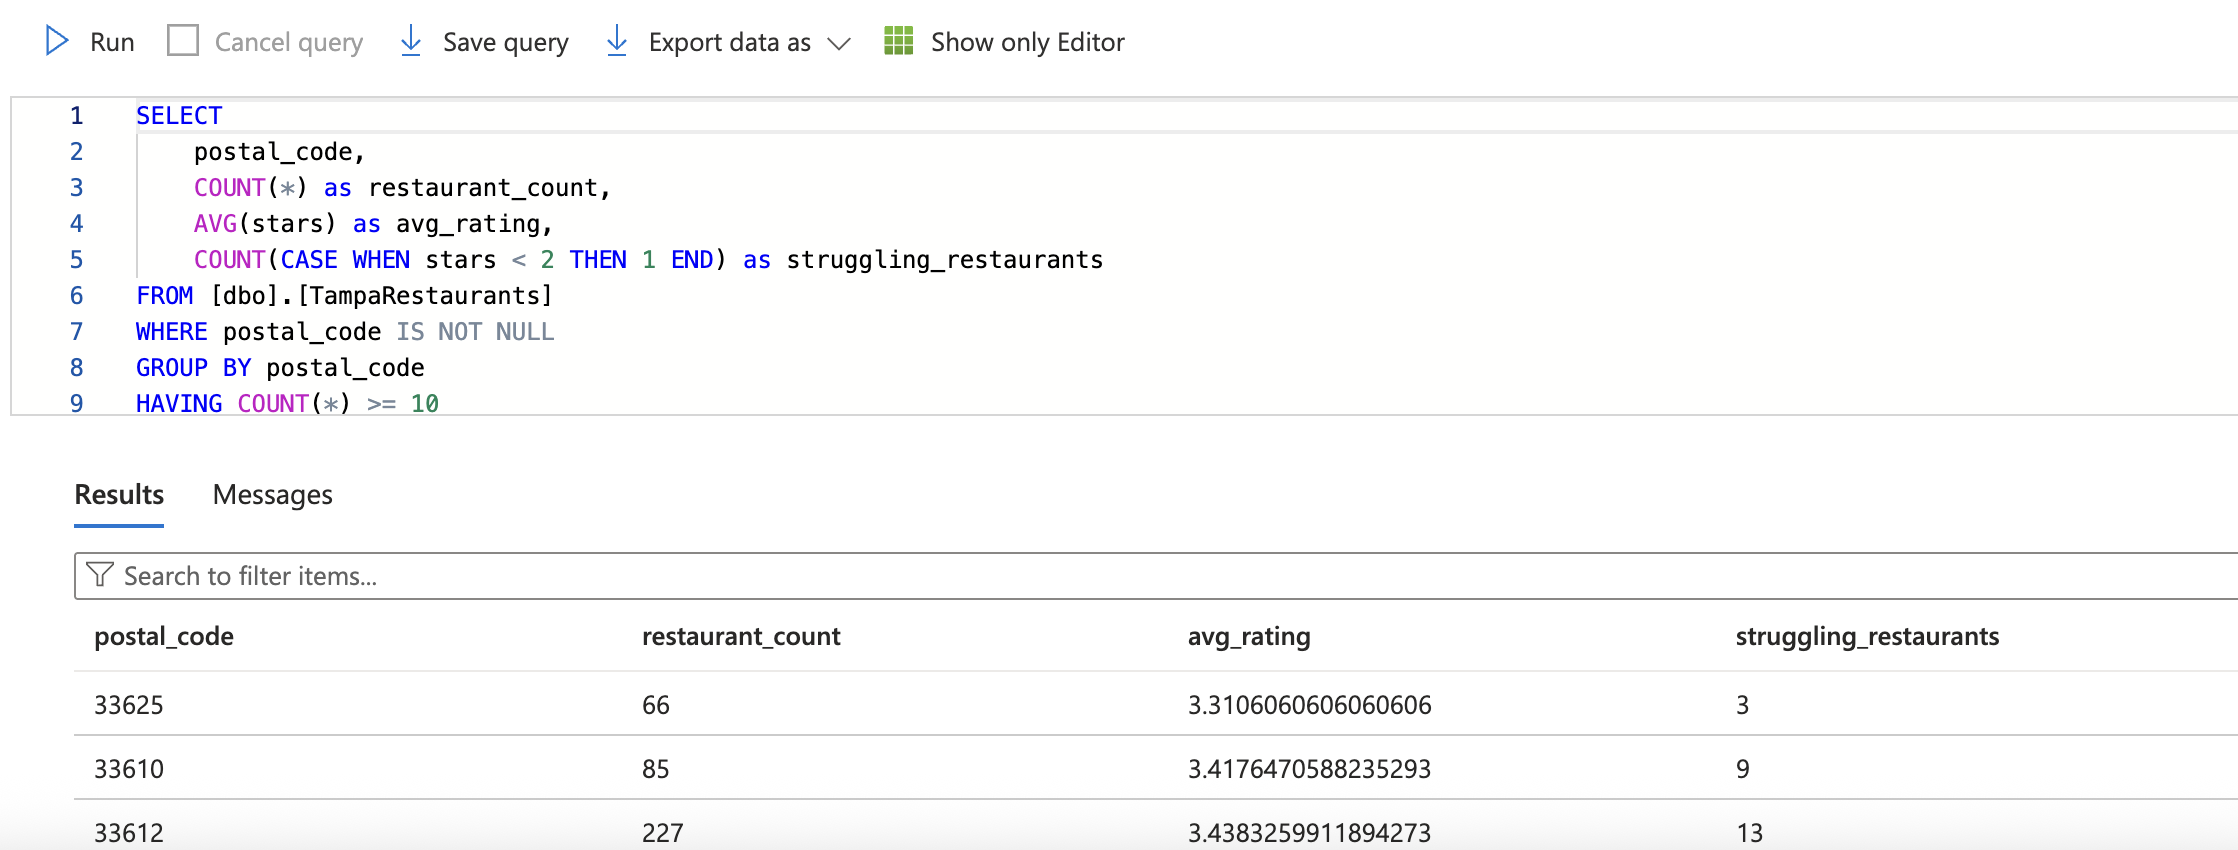

In [68]:
img7a = Image(filename='Query 7a.png')
display(img7a)

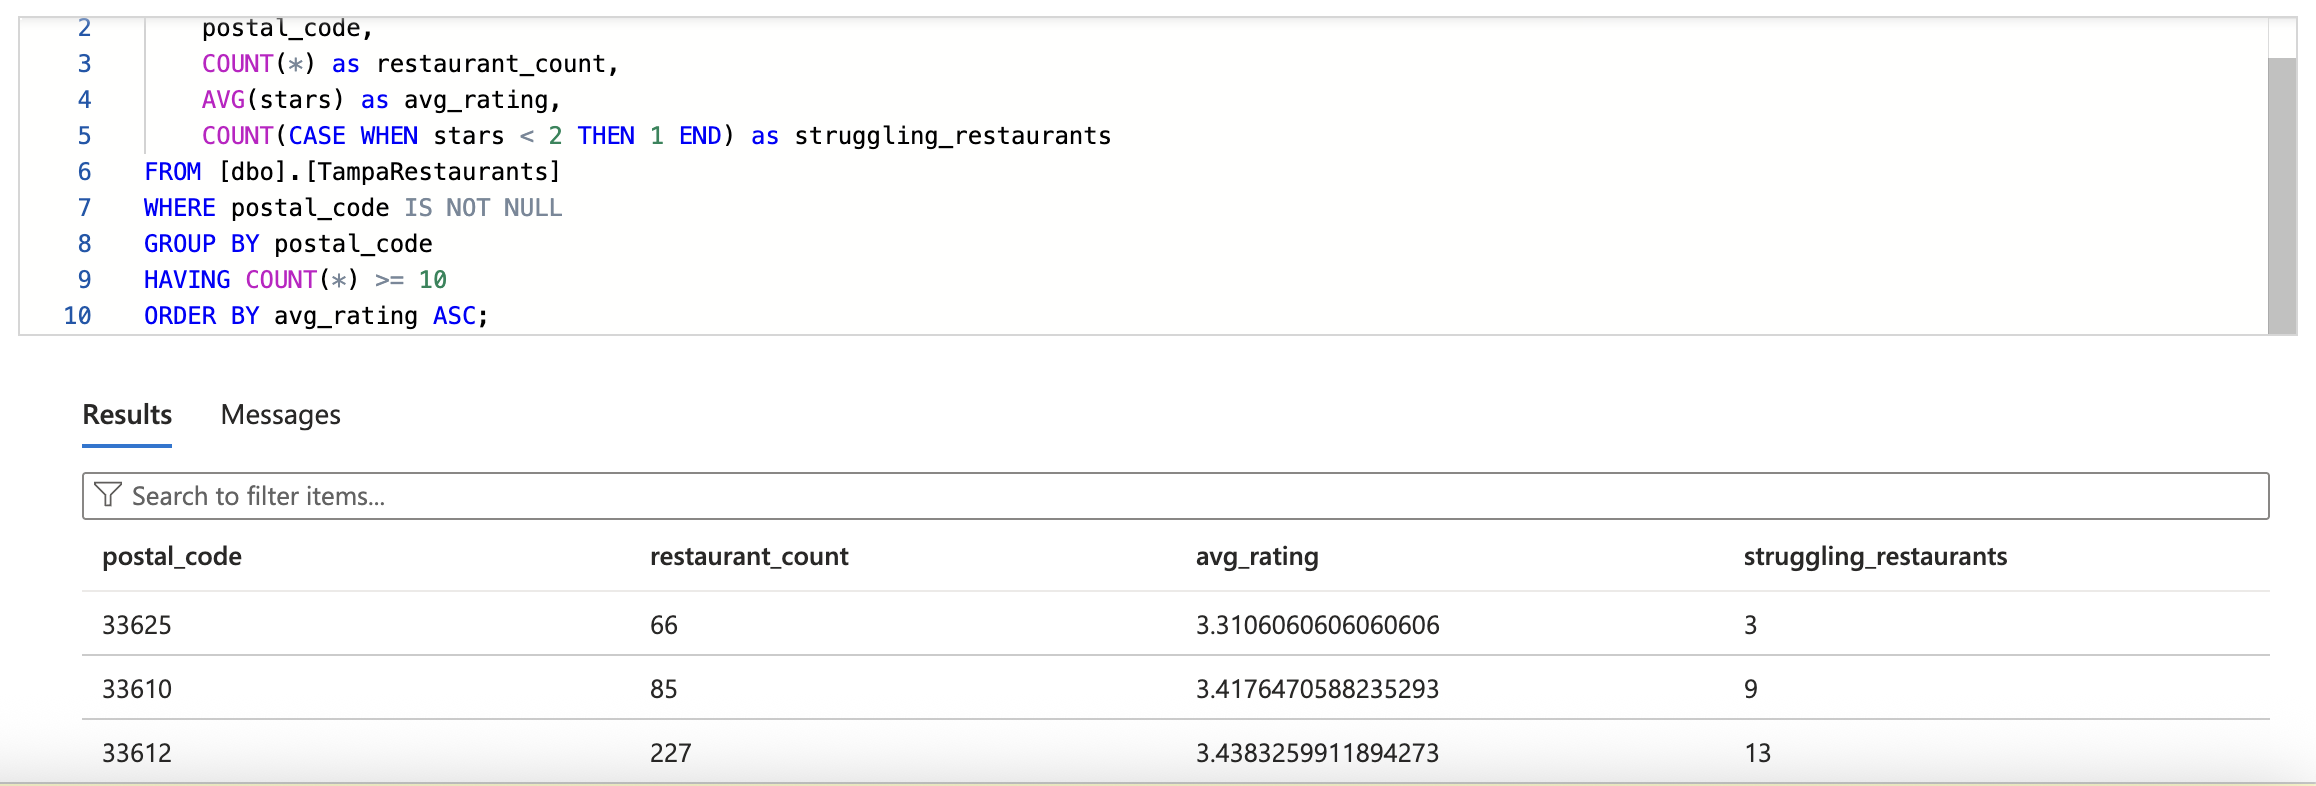

In [67]:
img7b = Image(filename='Query 7b.png')
display(img7b)

Which area have high disparities between the ratings of the restaurants which can show us which areas are more competitive. 

Results: Show rating_gap with disparities as big as 1.7 between to restaurants.

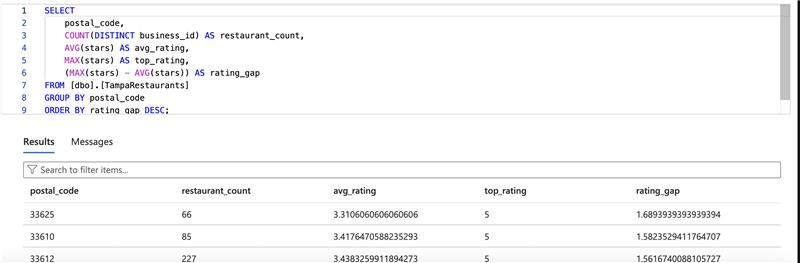

In [71]:
img8 = Image(filename='Query 8.jpeg')
display(img8)

What ratings are required to keep the restaurant open within the higher and lower ratings. 

Results: Show us the poor, fair, great categories for the reviews and shows us how many of them will survive. 

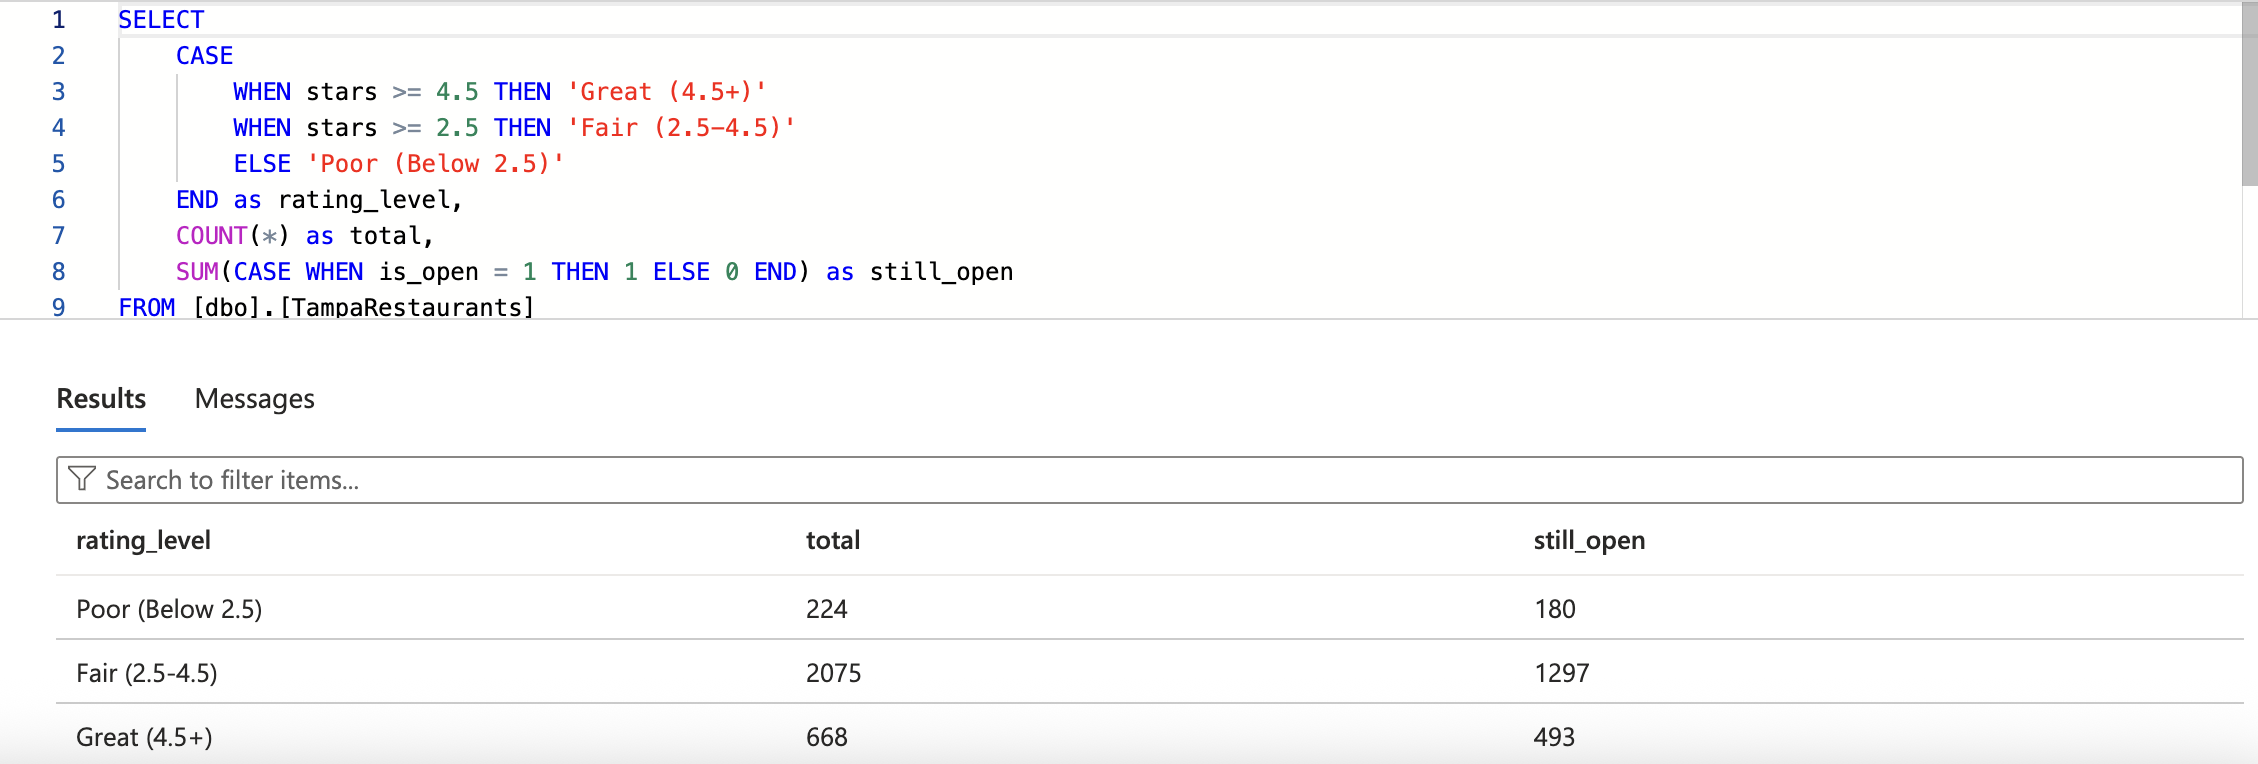

In [73]:
img9a = Image(filename='Query 9a.png')
display(img9a)

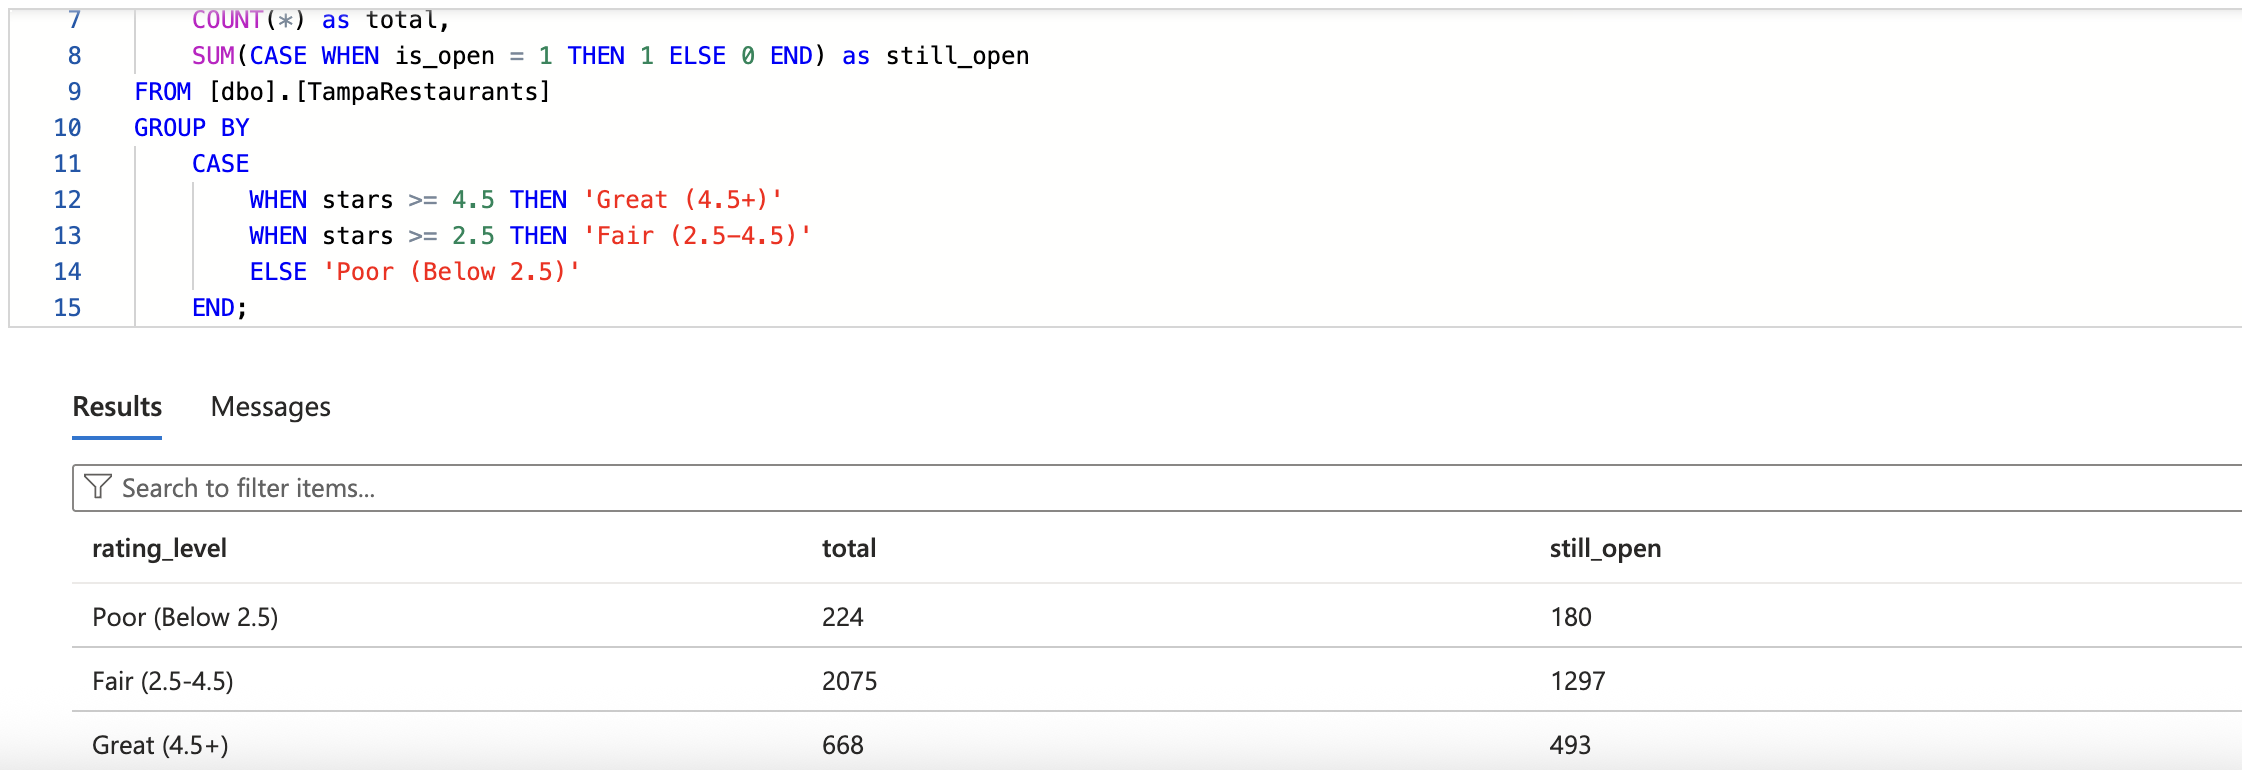

In [74]:
img9b = Image(filename='Query 9b.png')
display(img9b)

Cities with high average reviews per restaurant ikely have very active customers or popular restaurants — good for visibility and marketing. Cities with low averages may have lower engagement or less competition, offering potential opportunities for growth.

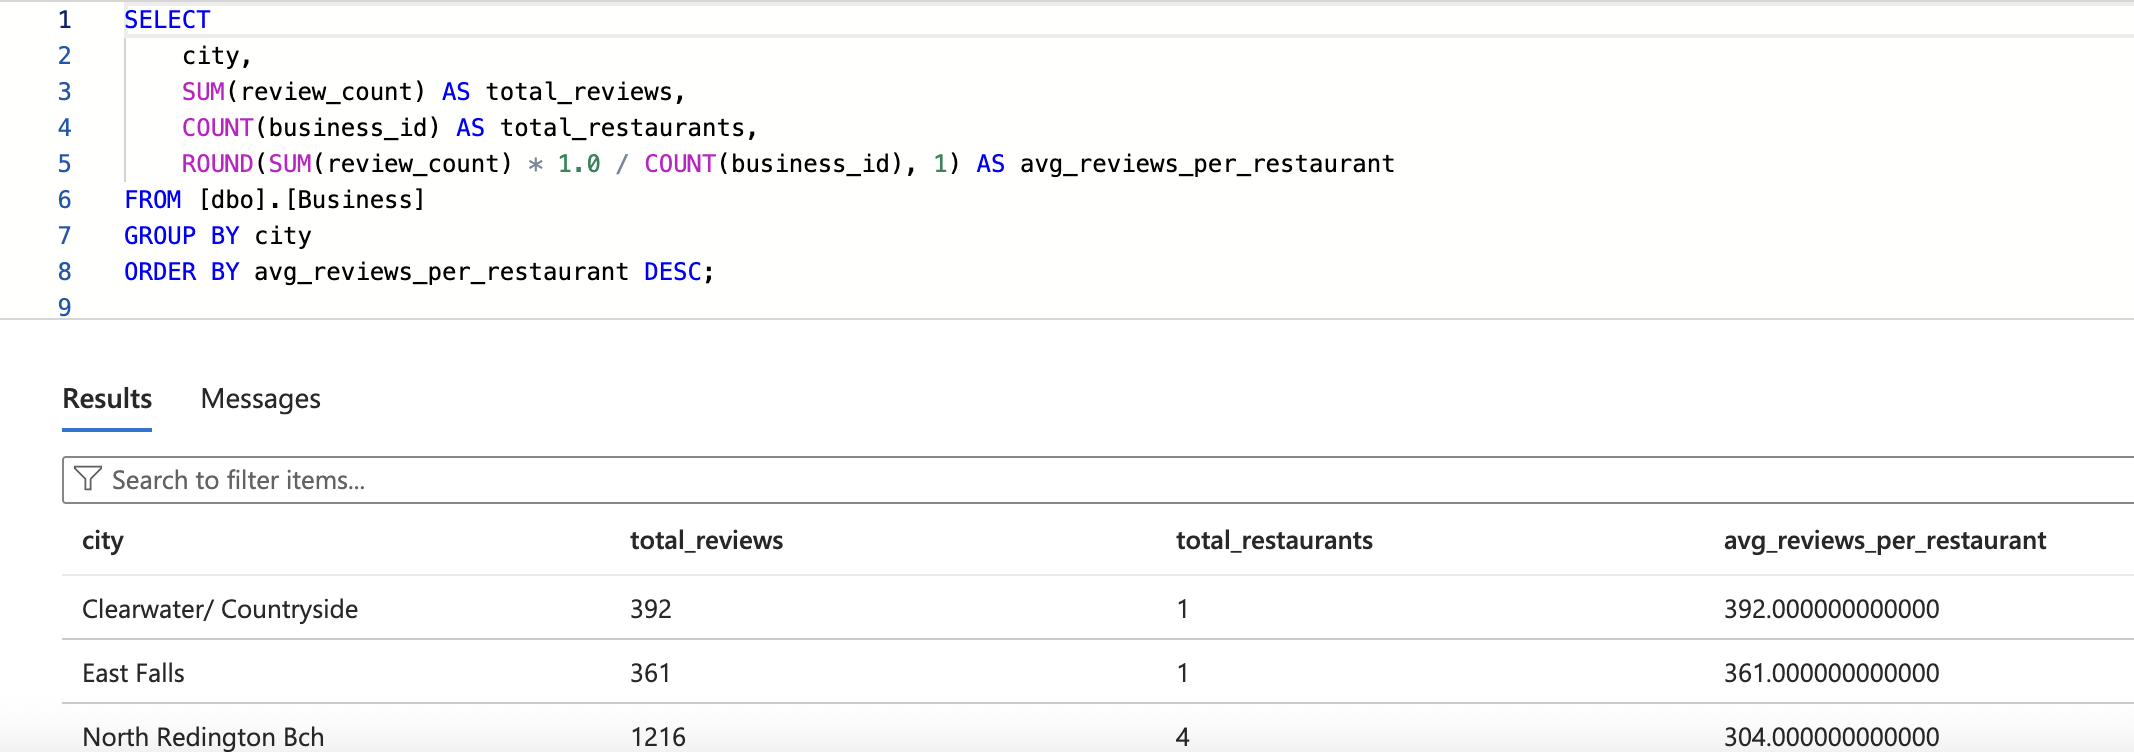

In [75]:
img10 = Image(filename='Query 10.png')
display(img10)